In [1]:
# !pip install igraph # for directed graph
# import igraph as ig

In [2]:
# !pip install networkx
import networkx as nx

In [3]:
import numpy as np
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import parse_input

In [4]:
from figure_2D import plot_undeployed_2D
from tools import get_center_position
import deploy_path as dp

In [5]:
def print_bumps_depressions(graph, bumps, depressions):
    print('\n--> bumps:')
    print(*[(b, graph.nodes[b]['height']) for b in bumps], sep='\n')
    print('\n--> depression:')
    print(*[(d, graph.nodes[d]['height']) for d in depressions], sep='\n')

### **Mesh Path**

In [6]:
from mesh_paths import  saddle_path,  igloo_coars_path, \
                        squid_path,   igloo_path,       \
                        peanut_path,  lilium_path,      \
                        hive_path,    trililium_path

In [7]:
mesh_path = squid_path

---

In [8]:
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(mesh_path, handleBoundary = False, isHex = False, use_target_surface = False)

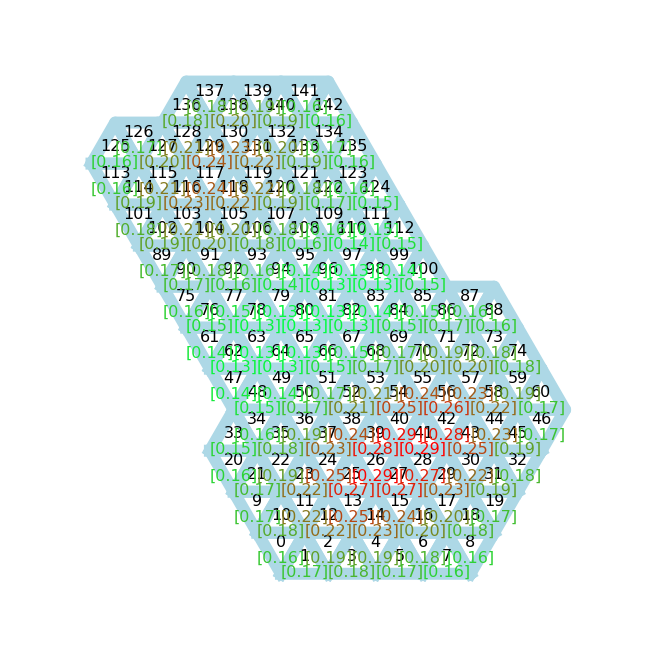

In [9]:
plot_undeployed_2D(input_data,
                   curr_um,
                   show_height=True,
                   show_plot=True)

In [10]:
connectivity = np.array(input_data['umbrella_connectivity'])
pos = get_center_position(curr_um)[:,:2]

In [11]:
graph = dp.create_graph(connectivity, curr_um)

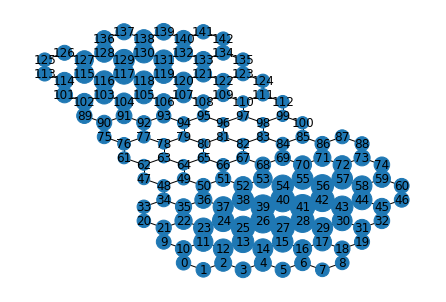

In [12]:
dp.draw_height(graph, pos, with_labels=True)

In [13]:
bumps, depressions = dp.find_extrems(graph, drop_boudary=True)

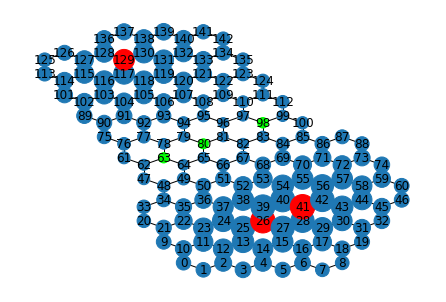


--> bumps:
(26, 0.2910722018484907)
(41, 0.29371571858847956)
(129, 0.23724376135437994)

--> depression:
(63, 0.1293838457028468)
(80, 0.12748595412189972)
(98, 0.13090008094655228)


In [14]:
# draw extrem points (bumps are red and depression are green)
dp.draw_height_extrems(graph, pos, bumps, depressions, with_labels=True)
print_bumps_depressions(graph, bumps, depressions)

In [15]:
paths = dp.shortes_paths(graph, bumps, depressions); paths

[[26, 39, 38, 52, 51, 66, 65, 80],
 [41, 40, 39, 38, 52, 51, 66, 65, 80],
 [129, 117, 118, 105, 106, 93, 94, 79, 80]]

In [16]:
# light_grey = 211/255
# colors_default = [(light_grey,light_grey,light_grey)] * len(graph) # light_grey

In [17]:
raise NotImplementedError('stop `run all` here to select some depressions in next cell')

NotImplementedError: stop `run all` here to select some depressions in next cell

In [18]:
kept_depressions = depressions

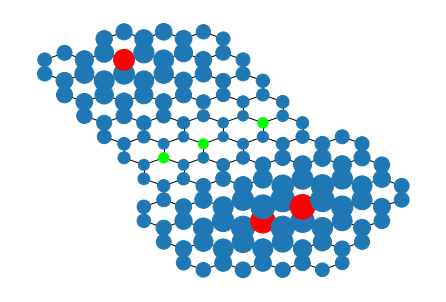

In [19]:
# draw extrem points (bumps are red and depression are green)
dp.draw_height_extrems(graph, pos, bumps, kept_depressions)

In [20]:
paths = dp.shortes_paths(graph, bumps, kept_depressions); paths

[[26, 39, 38, 52, 51, 66, 65, 80],
 [41, 40, 39, 38, 52, 51, 66, 65, 80],
 [129, 117, 118, 105, 106, 93, 94, 79, 80]]

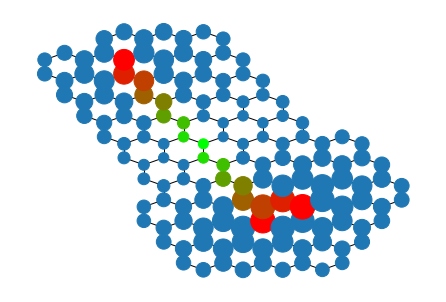

In [21]:
dp.draw_height_path(graph, pos, paths)

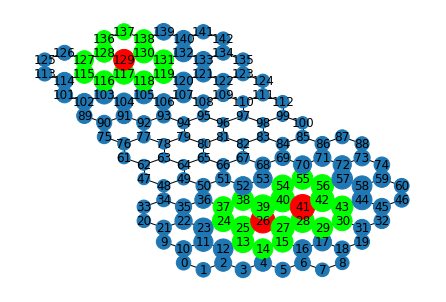

In [22]:
dp.draw_height_surrounds(graph, pos, dp.surround_bumps(graph, bumps), with_labels=True)

In [23]:
def surrounding(graph, bump, level=1, verbose=False):
    def surround(graph, prev_surr):
        'broken if drop_boundary=False'
        graph_copy = graph.copy()

        neighbors = []
        for pn in prev_surr:
            neighbors.extend([n for n in graph_copy.neighbors(pn) if n not in prev_surr])
            graph_copy.remove_node(pn)

        nb_neigh = len(neighbors)
        if nb_neigh==1 : return neighbors

        paths = []
        # not optimal, but necessary as we lose proximity information by keeping only unique units with numpy
        for i, source in enumerate(neighbors):
            for target in neighbors[i+1:]:
                try:
                    paths.extend(nx.shortest_path(graph_copy, source=source, target=target, weight=None))
                except nx.NetworkXNoPath: continue

        surroundings = list(np.unique(paths))

        return graph_copy, surroundings

    
    gr, sur = surround(graph, [bump])
    if verbose: dp.draw_height_extrems(graph, pos, [bump], sur, with_labels=True)
    for _ in range(level-1):
        gr, sur = surround(gr, sur)
        if sur==[]: break
        if verbose: dp.draw_height_extrems(graph, pos, [bump], sur, with_labels=True)
    return gr, sur

In [39]:
def surrounding_bumps(init_graph, bumps, level=1, verbose=False):
    ''' broken if hole in network...'''
    def surround(graph, prev_surr):
        print(bumps)
        'broken if drop_boundary=False'
        graph_copy = graph.copy()

        neighbors = []
        for pn in prev_surr:
            # if pn in level_surr and pn not in bumps: continue
            neighbors.extend([n for n in graph_copy.neighbors(pn) if n not in prev_surr])
            graph_copy.remove_node(pn)
            
        nb_neigh = len(neighbors)
        if nb_neigh==1 : return neighbors

        paths = []
        # not optimal, but necessary as we lose proximity information by keeping only unique units with numpy
        for i, source in enumerate(neighbors):
            for target in neighbors[i+1:]:
                try:
                    paths.extend(nx.shortest_path(graph_copy, source=source, target=target, weight=None))
                except nx.NetworkXNoPath: continue

        surroundings = list(np.unique(paths))

        # dp.draw_height_extrems(init_graph, pos, bumps, surroundings, with_labels=True)
        
        return surroundings


    prev_surr_dic = {}
    for b in bumps:
        prev_surr_dic[b] = [b]
        
    graph_shared = init_graph.copy()
    for _ in range(level):
        
        graph_level = graph_shared.copy()        
        for key, value in prev_surr_dic.items():
            surr = surround(graph_level, value) # remove surr_level ?
            prev_surr_dic[key] = surr
        
        surr_level = []
        for surr in prev_surr_dic.values():
            
            
        graph_shared.remove_nodes_from(surr_level) # if node not in graph, silently ignored
        
        
        
        dp.draw_height_extrems(init_graph, pos, bumps, surr_level, with_labels=True)
        
    return graph_shared, surr_level
            
        
        
    # if verbose: dp.draw_height_extrems(graph, pos, bumps, all_surr, with_labels=True)
    
    
        # for _ in range(level-1):
        #     gr, sur = surround(gr, sur)
        #     if sur==[]: break
        #     if verbose: dp.draw_height_extrems(graph, pos, [bump], sur, with_labels=True)

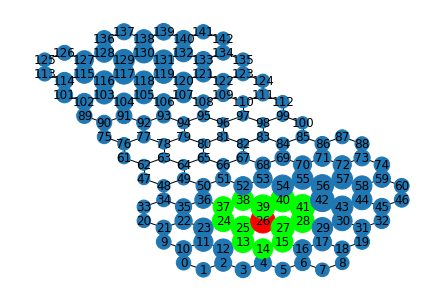

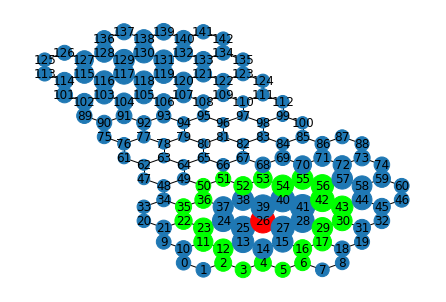

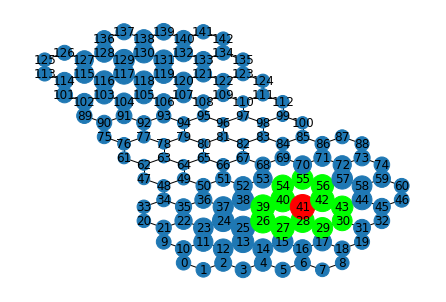

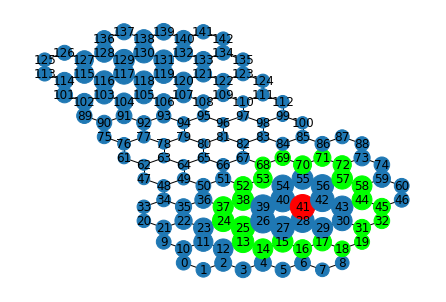

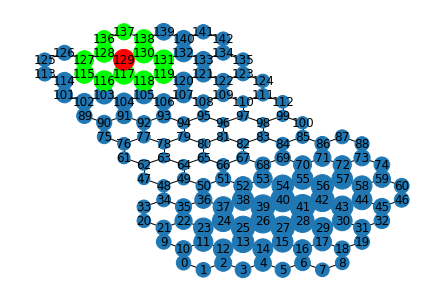

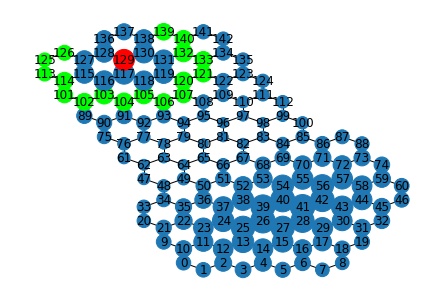

In [24]:
surrs = {}
for bump in bumps:
    _, surr = surrounding(graph, bump, level=2,verbose=True)
    surrs[bump] = surr

[26, 41, 129]
[26, 41, 129]
[26, 41, 129]


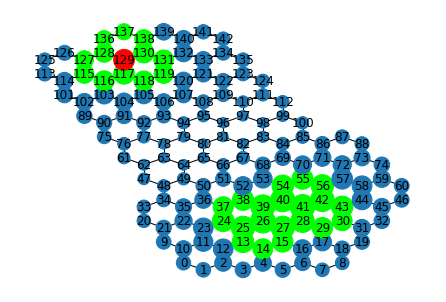

[26, 41, 129]


NetworkXError: The node 26 is not in the graph.

In [41]:
surrounding_bumps(graph, bumps, level=2, verbose=False)